In [ ]:
# !pip install pyspark

In [ ]:
# Timestamp	Open	High	Low	Close	Volume_(BTC)	Volume_(Currency)	Weighted_Pric

# Import Libraries

In [6]:
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
from pyspark.sql.functions import col

from pyspark.sql.functions import dayofweek, hour
from pyspark.sql.functions import lag
from pyspark.sql import functions as F

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.regression import GBTRegressor

from pyspark.sql.window import Window

import numpy as np
import pandas as pd

# Spark Context

In [2]:
spark = SparkSession.builder.appName("BitcoinDataProcessing").getOrCreate()

# Data Import

In [3]:
##--- This block is used for testing on a dump of the db---
# bitcoin_data_full = spark.read.csv("./bitcoin_historic_data.csv", header=True, inferSchema=True)

In [ ]:
jdbc_url = "jdbc:postgresql://localhost:5432/investmentdb"

connection_properties = {
    "user": "myuser",
    "password": "mypassword",
    "driver": "org.postgresql.Driver",
}

query = "(SELECT * FROM crypto_price_data WHERE SYMBOL LIKE '%BTC%') AS your_alias"

bitcoin_data = spark.read.jdbc(url=jdbc_url, table=query, properties=connection_properties)

In [7]:
bitcoin_data = bitcoin_data.orderBy(col("Timestamp").asc())
bitcoin_data = bitcoin_data.drop("symbol")

In [ ]:
bitcoin_data = bitcoin_data.withColumnRenamed("timestamp", "Timestamp") \
    .withColumnRenamed("open", "Open") \
    .withColumnRenamed("high", "High") \
    .withColumnRenamed("low", "Low") \
    .withColumnRenamed("close", "Close") \
    .withColumnRenamed("volume_crypto", "Volume_(BTC)") \
    .withColumnRenamed("volume_currency", "Volume_(Currency)") \
    .withColumnRenamed("weighted_price", "Weighted_Price")

In [8]:
bitcoin_data.toPandas()[['Close']].isnull().sum()

Close    1243608
dtype: int64

In [9]:
bitcoin_data.count()

4857377

In [10]:
type(bitcoin_data)

pyspark.sql.dataframe.DataFrame

In [11]:
bitcoin_data.show(10)

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

# Data Cleaning - Time stamp correction, Missing value treatment

In [12]:
# Converting the timestamp from unixtimestamp to a readable format
bitcoin_data = bitcoin_data.withColumn("Timestamp", bitcoin_data["Timestamp"].cast("timestamp"))

# Extracting the date part from the timestamp
bitcoin_data = bitcoin_data.withColumn("Date", F.to_date("Timestamp"))

# Define a window specification partitioned by date and ordered by timestamp
window_spec = Window.partitionBy("Date").orderBy("Timestamp")

# Getting the first record of each day
bitcoin_data = bitcoin_data.withColumn("row_num", F.row_number().over(window_spec)).filter(F.col("row_num") == 1).drop("row_num")


In [13]:
bitcoin_data.toPandas()[['Close']].isnull().sum(), bitcoin_data.toPandas()[['Close']].count()

(Close    675
 dtype: int64,
 Close    2700
 dtype: int64)

In [14]:
bitcoin_data.show(10)

+-------------------+----+----+----+-----+------------+-----------------+--------------+----------+
|          Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|      Date|
+-------------------+----+----+----+-----+------------+-----------------+--------------+----------+
|2011-12-31 13:22:00|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31|
|2012-01-01 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-01|
|2012-01-02 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-02|
|2012-01-03 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-03|
|2012-01-04 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-04|
|2012-01-05 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-05|
|2012-01-06 00:00:00| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2012-01-06|


In [15]:
bitcoin_data.count()

3375

In [16]:
from pyspark.sql.functions import col, when, last
from pyspark.sql.window import Window

other_columns = ["Weighted_Price", "Volume_(BTC)", "Volume_(Currency)"]
for col_name in other_columns:
#     bitcoin_data = bitcoin_data.withColumn(col_name, when(col(col_name).isNull(), 0).otherwise(col(col_name)))
    bitcoin_data = bitcoin_data.na.fill(value=0,subset=[col_name])

# Fill forward for OHLC data
# ohlc_columns = ["Open", "High", "Low", "Close"]
# for col_name in ohlc_columns:
#     # Create a window specification to fill forward based on timestamp
#     window_spec = Window.orderBy("Timestamp").rowsBetween(Window.unboundedPreceding, Window.currentRow)

#     # Fill forward using the last non-null value
#     bitcoin_data = bitcoin_data.withColumn(col_name, last(col_name, ignorenulls=True).over(window_spec))

# Fill forward for OHLC data    
ohlc_columns = ["Open", "High", "Low", "Close"]
bitcoin_data_pd = bitcoin_data.toPandas() # Converting to pandas df since Spark function not working as expected 
for col_name in ohlc_columns:
    bitcoin_data_pd[col_name].fillna(method='ffill', inplace=True)

bitcoin_data = spark.createDataFrame(bitcoin_data_pd)

In [17]:
# Shape (Number of Rows, Number of Columns)
num_rows = bitcoin_data.count()
num_columns = len(bitcoin_data.columns)

print("Shape: ({}, {})".format(num_rows, num_columns))

# Columns
columns = bitcoin_data.columns
print("Columns: {}".format(columns))

# Check for 'NaN' values
has_nan = bitcoin_data.select([col(c).isNull().alias(c) for c in bitcoin_data.columns]).rdd.flatMap(lambda x: x).collect()
any_nan = any(has_nan)

print("Is There any 'NaN' value: {}".format(any_nan))

# Check for duplicate values
has_duplicates = bitcoin_data.groupBy(bitcoin_data.columns).count().filter("count > 1").count() > 0

print("Is there any duplicate value: {}".format(has_duplicates))

Shape: (3375, 9)
Columns: ['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price', 'Date']
Is There any 'NaN' value: False
Is there any duplicate value: False


# Feature Engineering - Day of Week, 7 day prior information features

In [20]:
# Feature Engineering
# You can add features like day of the week, hour of the day, etc.
bitcoin_data = bitcoin_data.withColumn("DayOfWeek", dayofweek("Timestamp"))
bitcoin_data = bitcoin_data.withColumn("HourOfDay", hour("Timestamp"))

# Getting more features, last 7 days information to help predict next day closing (can increase more)

# Define the window specification
window_spec = Window().orderBy("Timestamp")

lag_cols = ["Open", "High", "Low", "Close", "Volume_(BTC)", "Volume_(Currency)"]

# Create lagged features for the last 7 days
for col_name in lag_cols:
    print(col_name)
    for j in range(1,8):
        bitcoin_data = bitcoin_data.withColumn(col_name + "_b_" + str(j), lag(col_name, j).over(window_spec))

bitcoin_data = bitcoin_data.dropna() # drop the first rows. They don't have previous information 
print("Updated Data Shape: ", bitcoin_data.count())

Open
High
Low
Close
Volume_(BTC)
Volume_(Currency)
Updated Data Shape:  3361


In [21]:
bitcoin_data.show(10)

+-------------------+----+----+----+-----+------------+-----------------+--------------+----------+---------+---------+---------+---------+---------+---------+---------+---------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+-------+-------+-------+-------+-------+-------+-------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+---------------------+
|          Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|      Date|DayOfWeek|HourOfDay|Close_b_1|Close_b_2|Close_b_3|Close_b_4|Close_b_5|Close_b_6|Close_b_7|Open_b_1|Open_b_2|Open_b_3|Open_b_4|Open_b_5|Open_b_6|Open_b_7|High_b_1|High_b_2|High_b_3|High_b_4|High_b_5|High_b_6|High_b_7|Low_b_1|Low_b_2|Low_b_3|Low_b_4|Low_b_5|

# Generate the Prediction label as next day close value

In [22]:
# Add next closing value as a label for prediction label
window_spec = Window().orderBy("Timestamp")

bitcoin_data = bitcoin_data.withColumn("upcoming_close", lag('Close', -1).over(window_spec))

bitcoin_data = bitcoin_data.dropna() # drop the last row. It doesn't have next information 
print("Updated record count after adding prediction close label:", bitcoin_data.count())

Updated record count after adding prediction close label: 3360


In [23]:
bitcoin_data.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume_(BTC)',
 'Volume_(Currency)',
 'Weighted_Price',
 'Date',
 'DayOfWeek',
 'HourOfDay',
 'Close_b_1',
 'Close_b_2',
 'Close_b_3',
 'Close_b_4',
 'Close_b_5',
 'Close_b_6',
 'Close_b_7',
 'Open_b_1',
 'Open_b_2',
 'Open_b_3',
 'Open_b_4',
 'Open_b_5',
 'Open_b_6',
 'Open_b_7',
 'High_b_1',
 'High_b_2',
 'High_b_3',
 'High_b_4',
 'High_b_5',
 'High_b_6',
 'High_b_7',
 'Low_b_1',
 'Low_b_2',
 'Low_b_3',
 'Low_b_4',
 'Low_b_5',
 'Low_b_6',
 'Low_b_7',
 'Volume_(BTC)_b_1',
 'Volume_(BTC)_b_2',
 'Volume_(BTC)_b_3',
 'Volume_(BTC)_b_4',
 'Volume_(BTC)_b_5',
 'Volume_(BTC)_b_6',
 'Volume_(BTC)_b_7',
 'Volume_(Currency)_b_1',
 'Volume_(Currency)_b_2',
 'Volume_(Currency)_b_3',
 'Volume_(Currency)_b_4',
 'Volume_(Currency)_b_5',
 'Volume_(Currency)_b_6',
 'Volume_(Currency)_b_7',
 'upcoming_close']

# Generate the Feature vector

In [24]:
#Input all the features in one vector column
feature_columns = [i for i in bitcoin_data.columns if i not in ['upcoming_close', 'Date', 'Timestamp']]
assembler = VectorAssembler(inputCols= feature_columns, outputCol = 'Attributes')

output = assembler.transform(bitcoin_data) #transform the data using Vector Assembler

#Input vs Output
finalized_data = output.select("Attributes","upcoming_close")

finalized_data.show() # showing the final data

+--------------------+--------------+
|          Attributes|upcoming_close|
+--------------------+--------------+
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          4.39|
|[4.39,4.39,4.39,4...|          6.01|
|[6.01,6.01,6.01,6...|          6.01|
|[6.01,6.01,6.01,6...|          6.01|
|[6.01,6.01,6.01,6...|          6.01|
|[6.01,6.01,6.01,6...|          6.01|
|[6.01,6.01,6.01,6...|          6.01|
|[6.01,6.01,6.01,6...|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
|[6.09,6.09,6.0,6....|           6.0|
+--------------------+--------------+


# Feature Vector and Train-Test Split

In [25]:
# Feature Selection
feature_columns = [i for i in bitcoin_data.columns if i not in ['upcoming_close', 'Date', 'Timestamp', 'HourOfDay']]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# bitcoin_data = assembler.transform(bitcoin_data)

# Train-Test Split - since the problem is time series, we should perform the sequenctial split
prediction_days = int(np.round(bitcoin_data.count()*(10/100),0))
train_data = bitcoin_data.orderBy(col('Timestamp').asc()).limit(int(bitcoin_data.count()-prediction_days))
test_data = bitcoin_data.orderBy(col('Timestamp').desc()).limit(prediction_days)

print("% test data = %", (prediction_days/int(bitcoin_data.count())) * 100)
print("Train data records:", train_data.count())
print("Test data records:", test_data.count())

% test data = % 10.0
Train data records: 3024
Test data records: 336


In [27]:
test_data.toPandas().head(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date,DayOfWeek,...,Volume_(BTC)_b_6,Volume_(BTC)_b_7,Volume_(Currency)_b_1,Volume_(Currency)_b_2,Volume_(Currency)_b_3,Volume_(Currency)_b_4,Volume_(Currency)_b_5,Volume_(Currency)_b_6,Volume_(Currency)_b_7,upcoming_close
0,2021-03-30,57839.02,57856.26,57829.68,57848.97,1.531218,88571.542443,57843.863514,2021-03-30,3,...,3.812537,1.483494,269492.333780,28900.966829,514987.501070,340670.711460,397241.333540,212908.312300,84434.674554,58952.12
1,2021-03-29,55564.49,55580.69,55500.00,55500.00,4.855304,269492.333780,55504.724414,2021-03-29,2,...,1.483494,0.044494,28900.966829,514987.501070,340670.711460,397241.333540,212908.312300,84434.674554,2551.177725,57848.97
2,2021-03-28,55716.60,55767.36,55671.09,55767.36,0.518993,28900.966829,55686.568000,2021-03-28,1,...,0.044494,4.184037,514987.501070,340670.711460,397241.333540,212908.312300,84434.674554,2551.177725,248650.340960,55500.00
3,2021-03-27,53767.33,53821.53,53764.65,53820.00,9.571039,514987.501070,53806.851949,2021-03-27,7,...,4.184037,1.006748,340670.711460,397241.333540,212908.312300,84434.674554,2551.177725,248650.340960,59191.078262,55767.36
4,2021-03-26,51737.65,51850.50,51732.51,51850.50,6.575495,340670.711460,51809.132983,2021-03-26,6,...,1.006748,3.244322,397241.333540,212908.312300,84434.674554,2551.177725,248650.340960,59191.078262,190090.044670,53820.00
5,2021-03-25,55889.73,55922.26,55816.43,55876.36,7.106350,397241.333540,55899.488670,2021-03-25,5,...,3.244322,5.329351,212908.312300,84434.674554,2551.177725,248650.340960,59191.078262,190090.044670,301925.117370,51850.50
6,2021-03-24,55814.11,55866.44,55811.29,55819.48,3.812537,212908.312300,55844.263899,2021-03-24,4,...,5.329351,1.554839,84434.674554,2551.177725,248650.340960,59191.078262,190090.044670,301925.117370,86043.644770,55876.36
7,2021-03-23,56981.47,56981.47,56905.62,56916.84,1.483494,84434.674554,56916.080758,2021-03-23,3,...,1.554839,2.027385,2551.177725,248650.340960,59191.078262,190090.044670,301925.117370,86043.644770,114281.215570,55819.48
8,2021-03-22,57320.22,57343.54,57307.34,57307.34,0.044494,2551.177725,57337.799390,2021-03-22,2,...,2.027385,0.056293,248650.340960,59191.078262,190090.044670,301925.117370,86043.644770,114281.215570,3378.559241,56916.84
9,2021-03-21,59385.62,59479.33,59310.17,59339.20,4.184037,248650.340960,59428.327416,2021-03-21,1,...,0.056293,7.497886,59191.078262,190090.044670,301925.117370,86043.644770,114281.215570,3378.559241,451280.999910,57307.34


In [28]:
train_data.toPandas().tail(10)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Date,DayOfWeek,...,Volume_(BTC)_b_6,Volume_(BTC)_b_7,Volume_(Currency)_b_1,Volume_(Currency)_b_2,Volume_(Currency)_b_3,Volume_(Currency)_b_4,Volume_(Currency)_b_5,Volume_(Currency)_b_6,Volume_(Currency)_b_7,upcoming_close
3014,2020-04-19,7026.10,7030.52,7024.38,7030.52,0.000000,0.000000,0.000000,2020-04-19,1,...,2.857050,0.505302,26030.185666,945.198752,10739.773029,6796.632998,51015.457284,20343.499225,3442.554274,7149.42
3015,2020-04-20,7153.71,7154.42,7149.42,7149.42,0.468102,3348.695554,7153.776281,2020-04-20,2,...,7.515120,2.857050,0.000000,26030.185666,945.198752,10739.773029,6796.632998,51015.457284,20343.499225,6866.16
3016,2020-04-21,6868.55,6870.69,6858.14,6866.16,8.604521,59069.340692,6864.918733,2020-04-21,3,...,0.979172,7.515120,3348.695554,0.000000,26030.185666,945.198752,10739.773029,6796.632998,51015.457284,6906.71
3017,2020-04-22,6903.41,6906.71,6903.41,6906.71,0.966465,6674.365420,6905.959393,2020-04-22,4,...,1.584160,0.979172,59069.340692,3348.695554,0.000000,26030.185666,945.198752,10739.773029,6796.632998,7094.95
3018,2020-04-23,7095.99,7095.99,7094.95,7094.95,0.539492,3827.690062,7094.988555,2020-04-23,5,...,0.134541,1.584160,6674.365420,59069.340692,3348.695554,0.000000,26030.185666,945.198752,10739.773029,7529.80
3019,2020-04-24,7522.86,7537.26,7522.86,7529.80,1.935177,14571.040487,7529.563602,2020-04-24,6,...,3.704662,0.134541,3827.690062,6674.365420,59069.340692,3348.695554,0.000000,26030.185666,945.198752,7530.00
3020,2020-04-25,7531.62,7532.19,7530.00,7530.00,15.690774,118167.504260,7531.018114,2020-04-25,7,...,0.000000,3.704662,14571.040487,3827.690062,6674.365420,59069.340692,3348.695554,0.000000,26030.185666,7537.57
3021,2020-04-26,7544.60,7545.41,7537.57,7537.57,0.669520,5051.512067,7544.975718,2020-04-26,1,...,0.468102,0.000000,118167.504260,14571.040487,3827.690062,6674.365420,59069.340692,3348.695554,0.000000,7616.19
3022,2020-04-27,7616.11,7622.11,7612.22,7616.19,0.460205,3504.181044,7614.388364,2020-04-27,2,...,8.604521,0.468102,5051.512067,118167.504260,14571.040487,3827.690062,6674.365420,59069.340692,3348.695554,7687.19
3023,2020-04-28,7690.08,7690.09,7687.19,7687.19,0.219373,1686.951306,7689.872774,2020-04-28,3,...,0.966465,8.604521,3504.181044,5051.512067,118167.504260,14571.040487,3827.690062,6674.365420,59069.340692,7749.52


# Linear Regressor

In [29]:
# Linear Regression Model
lr = LinearRegression(featuresCol="features", labelCol="upcoming_close")

# Pipeline
pipeline = Pipeline(stages=[assembler, lr])

# Model Training
model_lr = pipeline.fit(train_data)

# Model Evaluation using RMSE and R2 - LR

In [30]:
# Make predictions on the test data
predictions = model_lr.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

evaluator_r2 = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R2: {r2}")

# # View Predictions
# predictions.select("Close", "prediction", *feature_columns).show()

Root Mean Squared Error (RMSE): 1335.5159758584552
R2: 0.9926762789910054


In [31]:
# import joblib
    
# joblib.dump(model_lr, 'bitcoin_prediction_lr_model.joblib')    

In [32]:
predictions.select("upcoming_close", "prediction").show()

+--------------+------------------+
|upcoming_close|        prediction|
+--------------+------------------+
|      58952.12| 56971.03521485908|
|      57848.97| 56451.58820918595|
|       55500.0| 54748.19088480481|
|      55767.36| 53602.54663493955|
|       53820.0|51248.790204691344|
|       51850.5|  55748.1524527266|
|      55876.36| 55881.94686764233|
|      55819.48|55955.675645994874|
|      56916.84|57278.165056957136|
|      57307.34| 59603.82896388167|
|       59339.2| 58462.92115457379|
|      58799.71|58205.581094798916|
|      58620.45| 56742.33581926581|
|       56701.2| 54774.59040146435|
|       55384.6| 56593.08209414517|
|      56351.39| 59884.03219342655|
|      60014.23| 59929.10869953641|
|      60178.03| 57949.15903933616|
|      57344.48|56006.889120703185|
|      57121.81| 56064.25749187747|
+--------------+------------------+


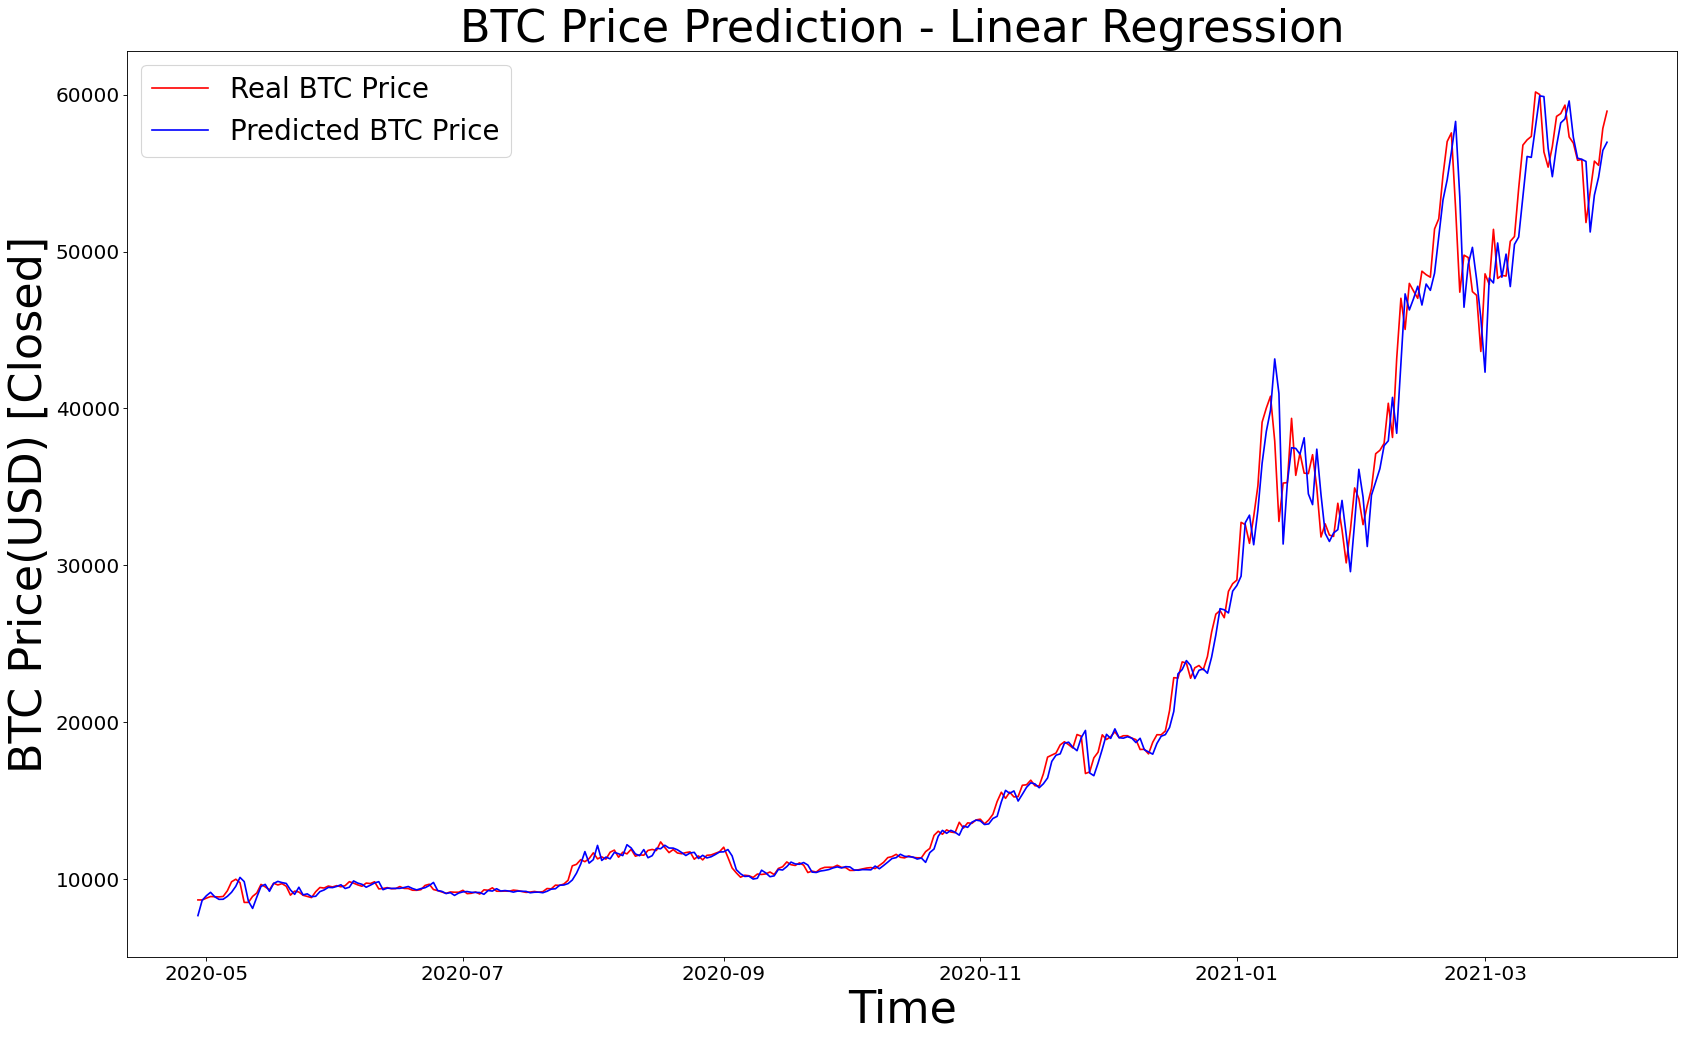

In [35]:
from matplotlib import pyplot as plt # to visualize

# predictions = model_lr.transform(test_data)

predictions = model_lr.transform(test_data)
pred_df = predictions.select('prediction', 'upcoming_close').toPandas()
pred_df['time_stamp'] = test_data.select('Timestamp').toPandas()

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(pred_df.time_stamp,pred_df.upcoming_close, color = 'red', label = 'Real BTC Price')
plt.plot(pred_df.time_stamp,pred_df.prediction, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction - Linear Regression', fontsize=40)
x = pred_df.time_stamp
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

# Random Forest Regressor

In [36]:
rf = RandomForestRegressor(featuresCol="features", labelCol="upcoming_close",
                           numTrees=1000, maxDepth=5, impurity='variance',seed=42)

# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

# Model Training
model_rf = pipeline.fit(train_data)

# Model Evaluation using RMSE and R2 - Random Forest

In [37]:
# Make predictions on the test data
predictions = model_rf.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

evaluator_r2 = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R2: {r2}")

# # View Predictions
# predictions.select("Close", "prediction", *feature_columns).show()

Root Mean Squared Error (RMSE): 16961.810588554872
R2: -0.18134850240108324


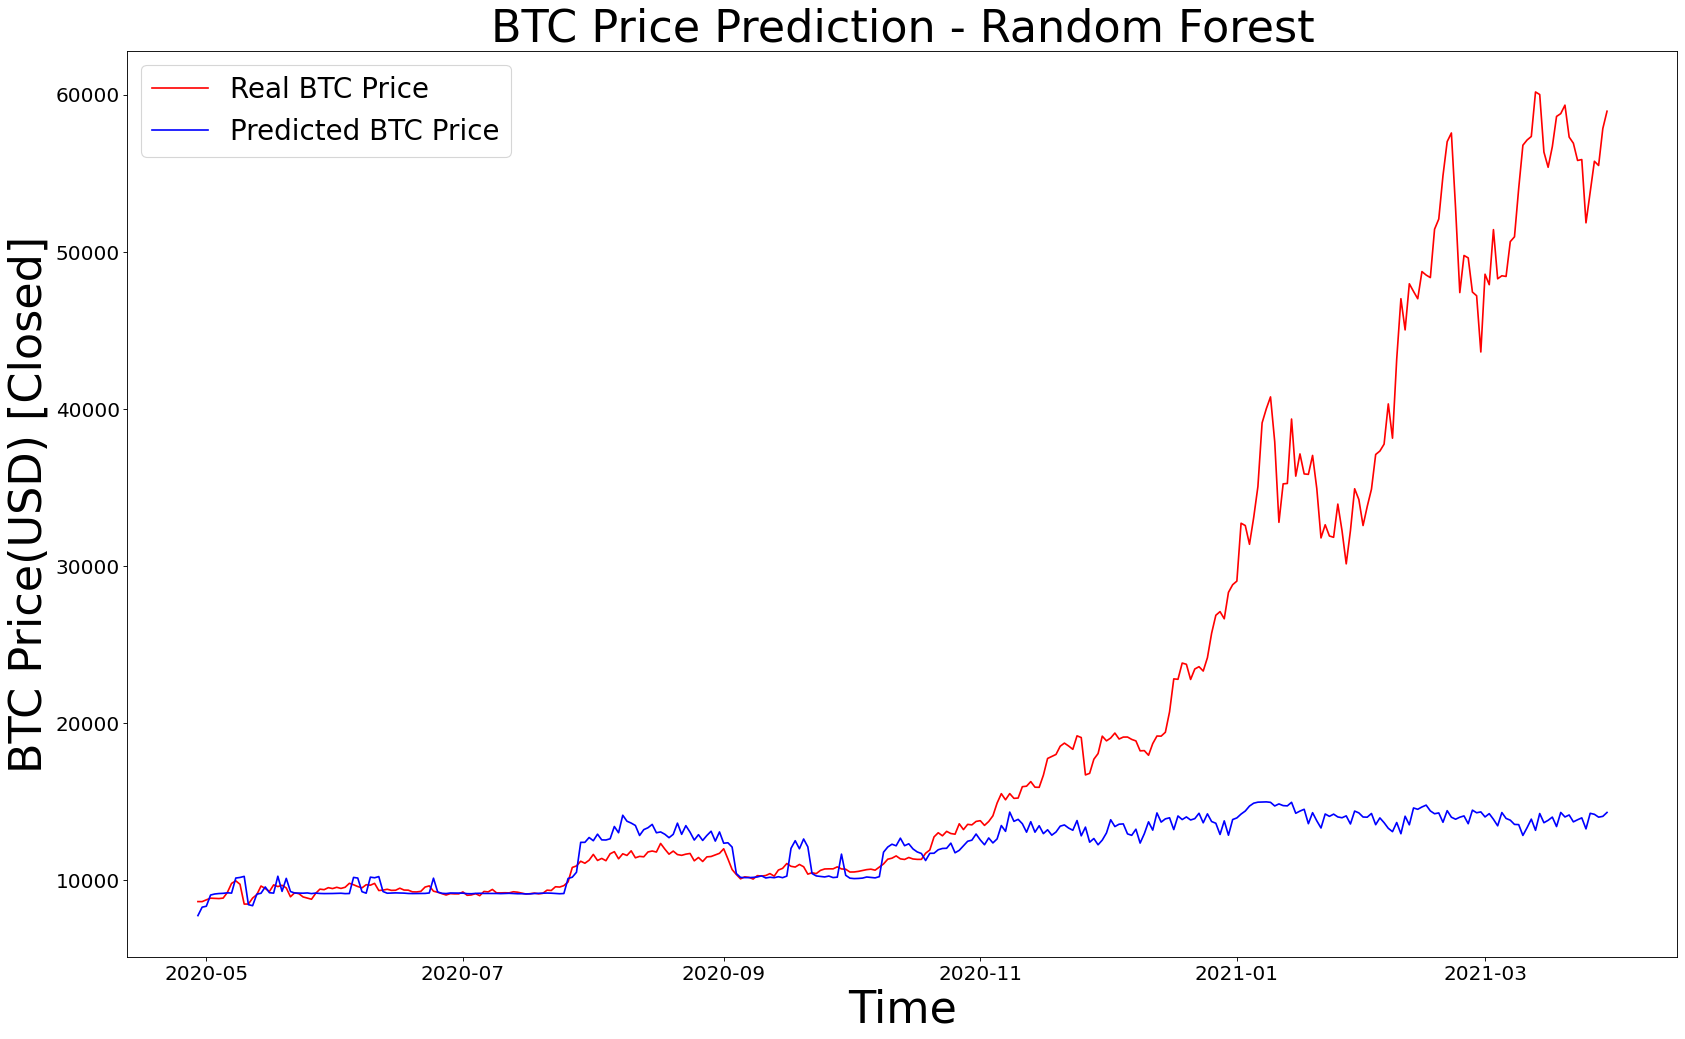

In [38]:
from matplotlib import pyplot as plt # to visualize

# predictions = model_lr.transform(test_data)

predictions = model_rf.transform(test_data)
pred_df = predictions.select('prediction', 'upcoming_close').toPandas()
pred_df['time_stamp'] = test_data.select('Timestamp').toPandas()

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(pred_df.time_stamp,pred_df.upcoming_close, color = 'red', label = 'Real BTC Price')
plt.plot(pred_df.time_stamp,pred_df.prediction, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction - Random Forest', fontsize=40)
x = pred_df.time_stamp
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()

# Boosting Regressor

In [39]:
gbt = GBTRegressor(featuresCol="features", labelCol="upcoming_close")

# Pipeline
pipeline = Pipeline(stages=[assembler, gbt])

# Model Training
model_gbt = pipeline.fit(train_data)

# Model Evaluation using RMSE and R2 - GBT

In [40]:
# Make predictions on the test data
predictions = model_gbt.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="rmse")
rmse = evaluator_rmse.evaluate(predictions)
print(f"Root Mean Squared Error (RMSE): {rmse}")

evaluator_r2 = RegressionEvaluator(labelCol="upcoming_close", predictionCol="prediction", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print(f"R2: {r2}")

# # View Predictions
# predictions.select("Close", "prediction", *feature_columns).show()

Root Mean Squared Error (RMSE): 16520.642279812186
R2: -0.12069509687804358


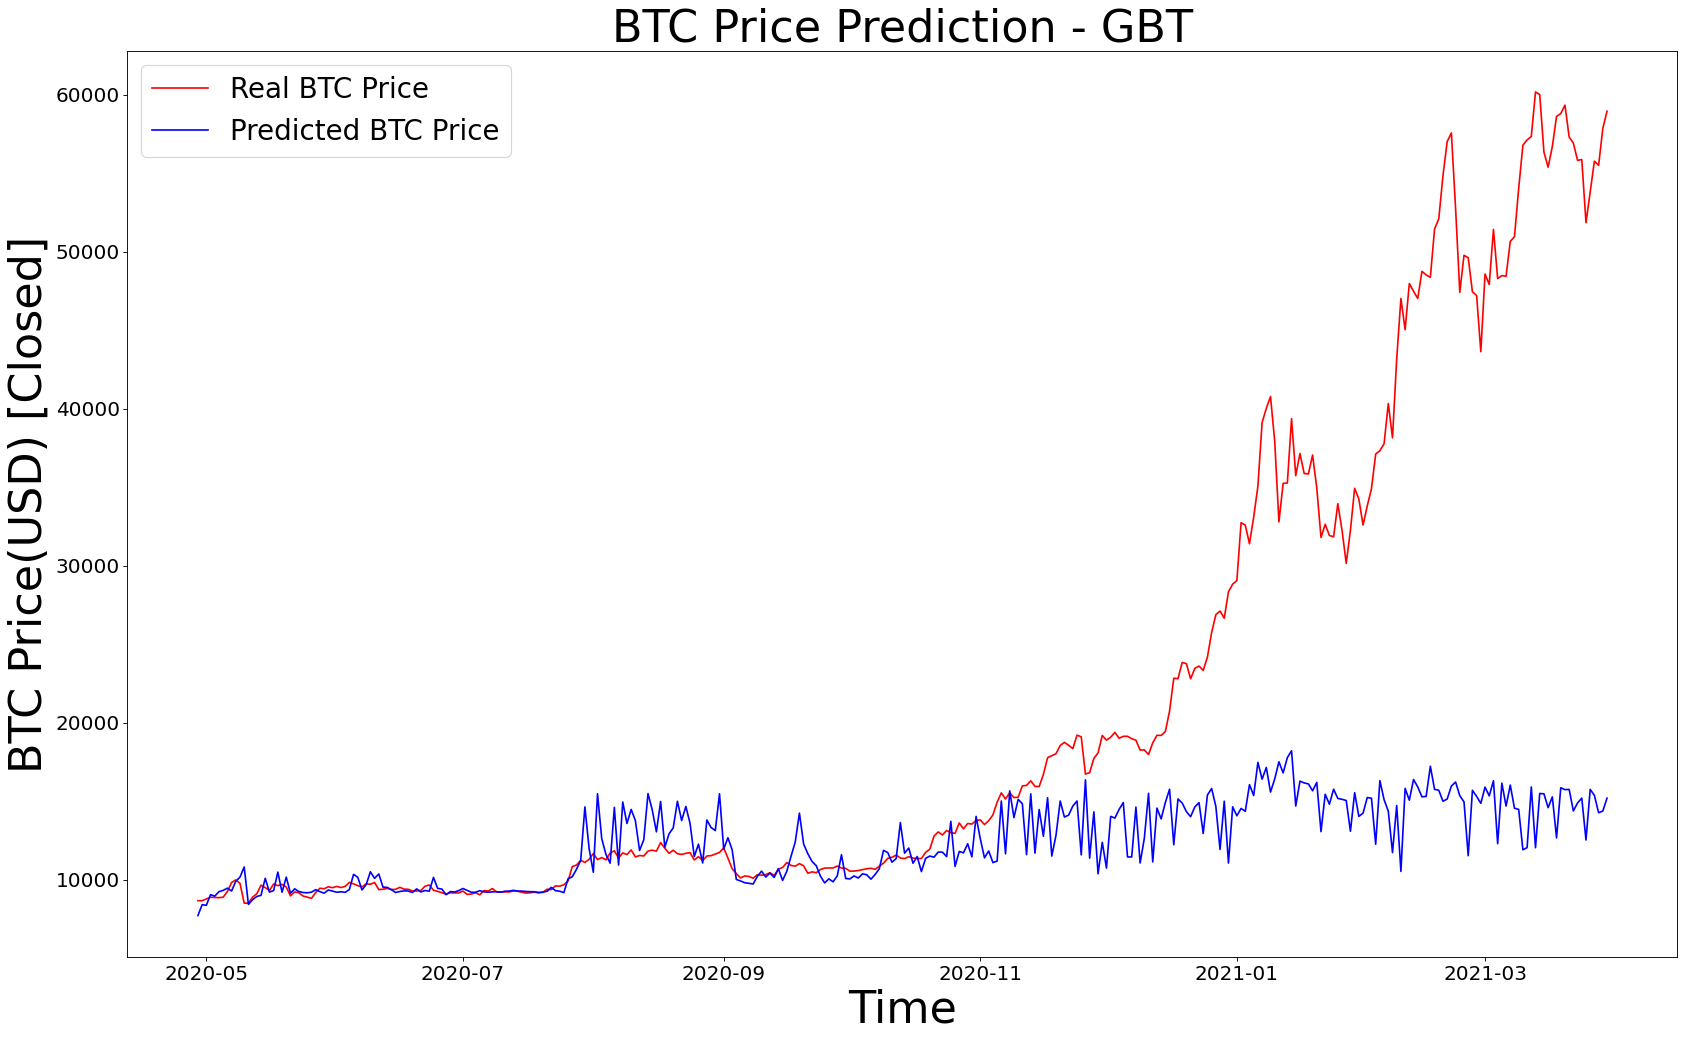

In [41]:
from matplotlib import pyplot as plt # to visualize

# predictions = model_lr.transform(test_data)

predictions = model_gbt.transform(test_data)
pred_df = predictions.select('prediction', 'upcoming_close').toPandas()
pred_df['time_stamp'] = test_data.select('Timestamp').toPandas()

# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(pred_df.time_stamp,pred_df.upcoming_close, color = 'red', label = 'Real BTC Price')
plt.plot(pred_df.time_stamp,pred_df.prediction, color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction - GBT', fontsize=40)
x = pred_df.time_stamp
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()